Dorrit0, dorrit1, jelle0, night0, night1

In [2]:
data_path_old = r"C:\Users\Fin Amin\Desktop/\StemCellResearch\datasets_Sahil_preprocessed_final-20220525T021621Z-001\datasets_Sahil_preprocessed_final\exp1"
matrix_path = "regulator-gene-matrix.csv"
data_path_syn = r"C:\Users\Fin Amin\Desktop\StemCellResearch\Fin_preProcessed\synData"
data_path_inter =  r"C:\Users\Fin Amin\Desktop\StemCellResearch\Fin_preProcessed\interpolatedOnly"
data_path_og_exp1 = r"C:\Users\Fin Amin\Desktop\StemCellResearch\Fin_preProcessed\datasets\exp1"
data_path_testSet = r"C:\Users\Fin Amin\Desktop\StemCellResearch\testSetFixed"
data_path_petal = r"C:\Users\Fin Amin\Desktop\StemCellResearch\petal_len.xlsx"

In [3]:
#!pip3 install keras-visualizer
#!pip install pydot
#data_path_og_exp1 = data_path_testSet 
!pip install pydot
!pip install pydotplus
!pip install graphviz

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [4]:
import tensorflow as tf
from tensorflow import keras
from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras_visualizer import visualizer 

from tensorflow.keras.layers import*
import shap
from keras.utils.vis_utils import plot_model
# from keras.layers import Input
# from keras.layers import Dense
# from keras.layers import Conv1D
# from keras.layers import Conv1DTranspose
# from keras.layers import Flatten, Reshape

import os
from glob import glob
from tqdm import tqdm
from tensorflow.keras import losses
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
import tensorboard

In [5]:
tf.executing_eagerly()

True

In [141]:
NUM_PARENTS = 21
NUM_TARGETS = 245

In [6]:
logdir="logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir)

In [7]:
import warnings
warnings.filterwarnings('ignore')

In [8]:
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 5),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)

# Load the test set and the synthetic dataset:


In [9]:
def loadTestSet(test_path):
    testFiles = []
    for np_name in glob(os.path.join(data_path_testSet,'*.np[yz]')):
        k = np.load(os.path.join(data_path_testSet,np_name))
        testFiles.append(k)
#         print(np_name)
#         print(k.shape)
    return np.array(testFiles)

In [118]:
test = loadTestSet(data_path_testSet)
testCandidate = test.astype(np.float)


In [11]:
def read_files(data_path):
    '''
    *Changed*
    currently hardcoded for only one file. 
    change code a bit for reading multiple files.
    '''
    #genes_intensities_data_matrix = pd.read_csv(file_path_intensities, index_col = 0)
    #print(os.listdir(data_path))
    replicate_files = os.listdir(data_path)
    #print('replicate files:',replicate_files)
    replicates = []
    # i = 0
    for file in replicate_files:
        
        try:
            #print('file name:',file)
            #print('value of i:',i)
            genes_intensities_data_matrix = pd.read_csv(os.path.join(data_path , file), index_col = 0, on_bad_lines='skip')
            #print('genes_intensities_data_matrix:',  genes_intensities_data_matrix.head())
            replicates.append(np.array(genes_intensities_data_matrix.values, dtype = float))
            # i+=1
        except PermissionError:
            print("Not a CSV: ", os.path.join(data_path , file))
        
    genes_intensities_data_matrix = genes_intensities_data_matrix.values
    rgm = np.loadtxt(matrix_path)
    rep = np.array(replicates).astype(np.float32)
    
    return rep, rgm.astype(np.float32)

In [12]:
genes_intensities_normalized, regulator_gene_matrix= read_files(data_path_syn)
matrix = regulator_gene_matrix
replicates = genes_intensities_normalized

In [13]:
matrix.shape

(245, 245)

In [14]:
replicates.shape

(6, 6, 245)

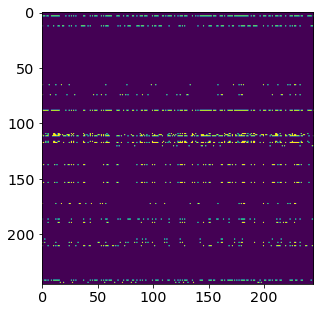

In [15]:
plt.imshow(matrix)

In [16]:
#%tensorflow_version 2.x
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


# Ordinary Auto Encoder

In [17]:
class EncoderLinear(tf.keras.layers.Layer):
    def __init__(self, rgm, input_dim=32, units=32):
        super(EncoderLinear, self).__init__()
        self.rgm = rgm
        
        def init_weights(shape, dtype="float32"):

            w_init = tf.random_normal_initializer()(shape=shape, dtype=dtype) * tf.convert_to_tensor(self.rgm, dtype=dtype)

            return w_init
        

        self.w = tf.Variable(
            initial_value=init_weights(shape=(input_dim, units), dtype="float32"),
            trainable=True,
        )

    def call(self, inputs):
        X = inputs
        return tf.matmul(X, tf.multiply(self.rgm, self.w))
    #tf.matmul(inputs, self.w)

In [18]:
class DecoderLinear(tf.keras.layers.Layer):
    def __init__(self, rgm, input_dim=32, units=32):
        super(DecoderLinear, self).__init__()
        self.rgm = rgm

        def init_weights(shape, dtype="float32"):

            w_init = tf.random_normal_initializer()(shape=shape, dtype=dtype) * tf.transpose(tf.convert_to_tensor(self.rgm, dtype=dtype))

            return w_init
    
        
        self.w = tf.Variable(
            initial_value=init_weights(shape=(input_dim, units), dtype="float32"),
            trainable=True,
        )

    def call(self, inputs):
        X = inputs
        #return tf.matmul(X, tf.multiply((self.rgm), self.w))
        X = tf.matmul(X, tf.multiply(tf.transpose(self.rgm), self.w)) 
        #return tf.matmul(inputs, self.w)
        # v = tf.zeros_like(X)
        # u = tf.ones_like(X)
        # u = tf.math.scalar_mul(-3.0, u)
        
        return X#tf.where(tf.math.less(X, v), u, X) #where X is less than 0, return -1 
        
        

In [105]:
def encoder(parent_child_biological_association, num_hidden_units=21):
    '''
    Encoder structure
    '''
    '''
    The data is time-series. Therefore, CNN to learn the temporal relationship between 
    the intensities for each gene.
    '''
    en_conv = Conv1D(490, 3, activation = "relu")(parent_child_biological_association) # 6*245 Conv1D(32, 3, activation = "relu")(parent_child_biological_association)
    en_dense = Flatten()(en_conv)
    phenotype = Dense(num_hidden_units)(en_dense)
    return phenotype

def decoder(X, num_protein_gene, time_steps):
    '''
    Decoder structure
    '''
    de_dense = Dense(1024)(X)#Dense(128)(X)
    de_dense = Reshape((1, 1024))(de_dense) #tf.reshape(de_dense, (self.batch_size,1,128))
    de_deconv = Conv1DTranspose(num_protein_gene, time_steps, activation = "relu")(de_dense) #used to be transpose
    #de_deconv = Conv1D(num_protein_gene, time_steps, activation = "relu")(de_dense) 
    # gene_reconstruction = self.decoder_biological_operation(de_deconv)
    return de_deconv

def model(rgm, num_protein_gene, time_steps, num_kinase_regulators, num_hidden_units = 21):
    inp = Input(shape=(time_steps, num_kinase_regulators))
    x = EncoderLinear(rgm, 245, 245)(inp)
    enc = encoder(x, num_hidden_units)
    dec = decoder(enc, num_protein_gene, time_steps)
    out = DecoderLinear(rgm, 245, 245)(dec)

    _model = tf.keras.Model(inputs=inp, outputs=out)

    return _model

In [106]:
regulator_gene_matrix = matrix# np.random.randint(0, 2, size=(245, 245)).astype(np.float32)


In [107]:
enc_dec_Synthetic = model(regulator_gene_matrix, 245, 6, 245) #we can just change the time steps to something higher

In [108]:
enc_dec_Synthetic.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 6, 245)]          0         
                                                                 
 encoder_linear (EncoderLine  (None, 6, 245)           60025     
 ar)                                                             
                                                                 
 conv1d (Conv1D)             (None, 4, 490)            360640    
                                                                 
 flatten (Flatten)           (None, 1960)              0         
                                                                 
 dense (Dense)               (None, 21)                41181     
                                                                 
 dense_1 (Dense)             (None, 1024)              22528     
                                                             

In [109]:
type(enc_dec_Synthetic)

keras.engine.functional.Functional

In [110]:
a = [1,2,3]
b = [5,6]
u = tf.concat([a,b], axis = 0)
u

<tf.Tensor: shape=(5,), dtype=int32, numpy=array([1, 2, 3, 5, 6])>

# Super Parent Matrix + Custom Loss
FOR USE LATER!!

In [111]:
superParent = regulator_gene_matrix.copy() #init the super parent with the ordinary RGM, and do forward passes with super parent
#print(superParent.shape)

ones = np.ones((245))
parentIndex = []
not_parentIndex = []
for i in range(len(regulator_gene_matrix)):
    if (np.isin(regulator_gene_matrix[i], [1])).any():
        #print(i)
        superParent[i] = ones 
        parentIndex.append(i)
    else:
        not_parentIndex.append(i)

parentIndex = np.array(parentIndex)
parentIndex = tf.convert_to_tensor(parentIndex)
not_parentIndex = np.array(not_parentIndex)
not_parentIndex = tf.convert_to_tensor(not_parentIndex)
print("shape of parent index", parentIndex.shape)

def ignore_noParent_MSE_old(y_true, y_pred): 
    l = tf.keras.losses.MeanSquaredError()
    y_true_pruned = tf.gather(y_true,parentIndex, axis =2)
    #print(y_true_pruned.shape
    y_pred_pruned = tf.gather(y_pred, parentIndex, axis =2)   
    return l(y_true_pruned, y_pred_pruned)

def ignore_noParent_MSE(y_true, y_pred): 
    l = tf.keras.losses.MeanSquaredError()

    y_true_pruned = tf.gather(y_true, parentIndex, axis = 2)
    #print(y_true_pruned)
    y_true_pruned = tf.reshape(y_true_pruned, shape=([tf.size(y_true_pruned)] ) )
    y_pred_pruned = tf.gather(y_pred, parentIndex, axis = 2) 
    y_pred_pruned = tf.reshape(y_pred_pruned, shape=([tf.size(y_pred_pruned)]) )

    y_true_posID = tf.where(y_true_pruned >= 0) #gets args
    y_true_posID = tf.squeeze(y_true_posID)

    y_true_negID = tf.where(y_true_pruned < 0) #get the idx of all the -1s in y_true
    y_true_negID = tf.squeeze(y_true_negID)
    y_true_neg = tf.gather(y_true_pruned, y_true_negID) #get all the -1s in y_true
    y_pred_neg = tf.gather(y_pred_pruned, y_true_negID) #get the corresponding values for y_pred

    y_shouldBeNegButIsntID = tf.where(y_pred_neg >= 0)  
    y_shouldBeNegButIsntID = tf.squeeze(y_shouldBeNegButIsntID) #get the idx which should be -1 for prediction but are not
    y_true_wrong = tf.gather(y_true_pruned, y_shouldBeNegButIsntID) #get the same corresponding values from ypred
    y_shouldBeNegButIsnt = tf.gather(y_pred_pruned, y_shouldBeNegButIsntID) #this has all the wrongly predicted values which should be -1 but are not

    y_true_pos = tf.gather(y_true_pruned, y_true_posID)
    y_pred_pos = tf.gather(y_pred_pruned, y_true_posID)

    y_pred_total = tf.concat([y_pred_pos, y_shouldBeNegButIsnt], axis = 0) #concatenate for total mse
    y_true_total = tf.concat([y_true_pos, y_true_wrong], axis = 0)

    return l(y_true_total, y_pred_total)

shape of parent index (21,)


In [112]:
###Code for testing loss function
# print(outSyn.shape)
# print(testCandidate.shape)
# syntheticLoss = ignore_noParent_MSE(np.array([testCandidate[0]]), np.array([outSyn[0]]) )
# syntheticLoss

# Synthetic Dataset Auto Encoder
Autoencoder has not been trained on synthetic version of experiement 1. We test on the original experiment 1. 

In [113]:
enc_dec_Synthetic.compile(optimizer='adam', loss=ignore_noParent_MSE)

In [114]:
# enc_dec_Synthetic.compile(optimizer='adam',loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True))

In [115]:
syntheticDataTrain = genes_intensities_normalized[1:]

In [116]:
enc_dec_Synthetic.fit(syntheticDataTrain,syntheticDataTrain,epochs=1000)

Epoch 1/1000
1/1 [==============================] - 2s 2s/step - loss: 1.0077
Epoch 2/1000
1/1 [==============================] - 0s 7ms/step - loss: 0.9330
Epoch 3/1000
1/1 [==============================] - 0s 6ms/step - loss: 0.8959
Epoch 4/1000
1/1 [==============================] - 0s 5ms/step - loss: 0.8418
Epoch 5/1000
1/1 [==============================] - 0s 5ms/step - loss: 0.6885
Epoch 6/1000
1/1 [==============================] - 0s 7ms/step - loss: 0.6528
Epoch 7/1000
1/1 [==============================] - 0s 7ms/step - loss: 0.3759
Epoch 8/1000
1/1 [==============================] - 0s 7ms/step - loss: 0.3321
Epoch 9/1000
1/1 [==============================] - 0s 8ms/step - loss: 0.3571
Epoch 10/1000
1/1 [==============================] - 0s 6ms/step - loss: 0.2582
Epoch 11/1000
1/1 [==============================] - 0s 6ms/step - loss: 0.1705
Epoch 12/1000
1/1 [==============================] - 0s 12ms/step - loss: 0.1536
Epoch 13/1000
1/1 [==============================

In [117]:
test = enc_dec_Synthetic(testCandidate) #, verbose = 0)
loss = ignore_noParent_MSE(testCandidate, test)
loss

<tf.Tensor: shape=(), dtype=float32, numpy=0.30939686>

In [31]:
w = enc_dec_Synthetic.get_weights()

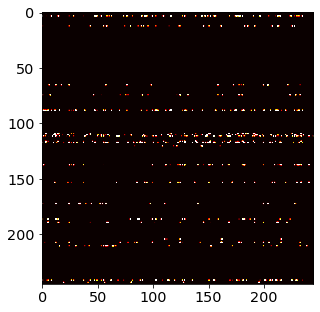

In [32]:
plt.imshow(w[0], cmap = "hot", vmin=0,vmax=0.02)

In [33]:
#we do not need to use this function for the testset
def getCSVs(data_path_head):
    PATH = data_path_head
    EXT = "*.csv"
    all_csv_files = [file
                     for path, subdir, files in os.walk(PATH)
                     for file in glob(os.path.join(path, EXT))]
    actual = []
    for p in all_csv_files:
        actual.append(pd.read_csv(p, index_col = 0).to_numpy())
    return np.array(actual)
    
experiment1 = getCSVs(data_path_og_exp1)

In [34]:
testCandidate = test.astype(np.float)

In [35]:
testCandidate.dtype

dtype('float64')

In [36]:
np.array([genes_intensities_normalized[0]]).shape

(1, 6, 245)

In [37]:
testCandidate[0].shape

(6, 245)

In [38]:
np.array([genes_intensities_normalized[0]]).shape

(1, 6, 245)

In [39]:
outSyn = enc_dec_Synthetic.predict(testCandidate)

1/1 [==============================] - 0s 259ms/step


In [40]:
def mymagn(A, B):
    mse = (np.square(A - B)).mean(axis=None)
    return mse

In [41]:
print(outSyn.shape)

(4, 6, 245)


In [42]:
syntheticLoss = ignore_noParent_MSE(testCandidate, outSyn )
syntheticLoss

<tf.Tensor: shape=(), dtype=float32, numpy=0.31326497>

In [43]:
(outSyn-testCandidate).shape

(4, 6, 245)

# Interpolated dataset Auto Encoder
Once again, we do not train on any version of exp1

In [119]:
def read_filesV2(data_path):
    '''
    *Changed*
    currently hardcoded for only one file. 
    change code a bit for reading multiple files.
    '''
    #genes_intensities_data_matrix = pd.read_csv(file_path_intensities, index_col = 0)
    #print(os.listdir(data_path))
    replicate_files = os.listdir(data_path)
    #print('replicate files:',replicate_files)
    replicates = []
    # i = 0
    for file in replicate_files:
        
        #print('file name:',file)
        #print('value of i:',i)
        genes_intensities_data_matrix = pd.read_csv(os.path.join(data_path , file), index_col = 0, on_bad_lines='skip')
        #print('genes_intensities_data_matrix:',  genes_intensities_data_matrix.head())
        replicates.append(genes_intensities_data_matrix.values)
        # i+=1
        
    genes_intensities_data_matrix = genes_intensities_data_matrix.values
    rgm = np.loadtxt(matrix_path)
    
    return np.asarray(replicates), rgm.astype(np.float32)

In [120]:
interpolated_genes, _ = read_filesV2(data_path_inter)

In [121]:
interpolated_genes.shape

(5,)

In [122]:
pd.DataFrame(interpolated_genes[2]).head(5)

,0,1,2,3,4,5,6,7,8,9,...,235,236,237,238,239,240,241,242,243,244
0,0.254943,-1.000000,0.663585,0.440312,-1.000000,0.635664,0.734571,-1.000000,0.312044,0.602692,...,-1.000000,0.400712,-1.000000,0.523033,-1.000000,0.561590,0.403879,0.642049,-1.000000,0.443478
1,0.338509,-1.000000,0.612395,0.655007,-1.000000,-1.000000,0.590564,-1.000000,0.353872,0.539972,...,-1.000000,0.445519,-1.000000,0.586067,-1.000000,0.541903,0.426403,0.495559,0.550973,0.419991
2,-1.000000,0.544463,0.596307,0.596367,-1.000000,0.629406,0.579586,0.726602,-1.000000,0.535278,...,0.509166,-1.000000,-1.000000,0.642262,-1.000000,0.586480,0.569283,-1.000000,0.596188,-1.000000
3,-0.329754,-0.454583,-0.828393,0.582746,-0.689224,0.178233,0.309607,-0.297329,-0.461788,0.493608,...,-0.024981,-0.697509,-0.153204,0.546957,0.161868,0.291320,-0.109625,-0.444279,0.007077,-0.254379
4,-1.000000,0.528085,-1.000000,0.523557,-1.000000,0.588043,0.580612,-1.000000,0.354997,0.567674,...,0.573489,0.392001,-1.000000,0.602732,-1.000000,0.544163,0.423905,-1.000000,0.578650,-1.000000


In [123]:
inter = []
for k in range(len(interpolated_genes)):
    #print(k)
    if k == 2 or k == 3 or k == 4:
        inter.append(np.reshape(interpolated_genes[k], (4,6,245)))
    else: 
        inter.append(np.reshape(interpolated_genes[k], (5,6,245)))
inter = np.vstack(inter)

In [124]:
inter.shape

(22, 6, 245)

In [125]:
genes_intensities_normalized[1:].shape

(5, 6, 245)

In [126]:
enc_dec_inter = model(regulator_gene_matrix, 245, 6, 245) 
enc_dec_inter.compile(optimizer='adam', loss=ignore_noParent_MSE)

In [127]:
enc_dec_inter.fit(inter, inter,epochs=1000);

Epoch 1/1000
1/1 [==============================] - 1s 1s/step - loss: 0.2924
Epoch 2/1000
1/1 [==============================] - 0s 8ms/step - loss: 0.2936
Epoch 3/1000
1/1 [==============================] - 0s 9ms/step - loss: 0.2937
Epoch 4/1000
1/1 [==============================] - 0s 7ms/step - loss: 0.2696
Epoch 5/1000
1/1 [==============================] - 0s 7ms/step - loss: 0.2396
Epoch 6/1000
1/1 [==============================] - 0s 8ms/step - loss: 0.2253
Epoch 7/1000
1/1 [==============================] - 0s 11ms/step - loss: 0.2165
Epoch 8/1000
1/1 [==============================] - 0s 25ms/step - loss: 0.2062
Epoch 9/1000
1/1 [==============================] - 0s 6ms/step - loss: 0.1890
Epoch 10/1000
1/1 [==============================] - 0s 6ms/step - loss: 0.1631
Epoch 11/1000
1/1 [==============================] - 0s 11ms/step - loss: 0.1665
Epoch 12/1000
1/1 [==============================] - 0s 14ms/step - loss: 0.1490
Epoch 13/1000
1/1 [===========================

In [128]:
outInter = enc_dec_inter.predict(testCandidate)
interpolationLoss = ignore_noParent_MSE(testCandidate, outInter)

1/1 [==============================] - 0s 142ms/step


In [129]:
interpolationLoss #used to be 3.84 on broke ignore

<tf.Tensor: shape=(), dtype=float32, numpy=0.33087447>

In [55]:
outInter.shape

(4, 6, 245)

In [56]:
u = enc_dec_inter.history
u

# Comparisons between various outputs:

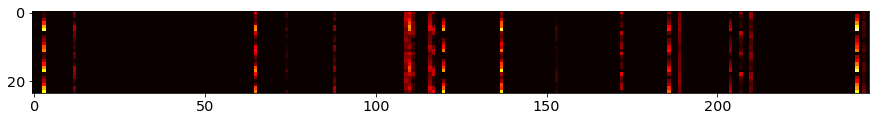

In [57]:
u = plt.imshow(np.reshape((np.abs(outSyn)), (24,245)), cmap = "hot", vmin=0,vmax=1.0 );

In [58]:
u = pd.DataFrame(outSyn[0])
u.head(10)

,0,1,2,3,4,5,6,7,8,9,...,235,236,237,238,239,240,241,242,243,244
0,0.0,0.0,0.0,-0.060659,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.006435,0.0,-0.064178,0.0
1,0.0,0.0,0.0,0.083893,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.273670,0.0,-0.078267,0.0
2,0.0,0.0,0.0,0.225896,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.390148,0.0,0.030251,0.0
3,0.0,0.0,0.0,0.417360,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.570473,0.0,0.095983,0.0
4,0.0,0.0,0.0,0.618410,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.736997,0.0,0.094355,0.0
5,0.0,0.0,0.0,0.792913,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.937159,0.0,0.075580,0.0


In [59]:
u = pd.DataFrame(testCandidate[0])
u.head(10)

,0,1,2,3,4,5,6,7,8,9,...,235,236,237,238,239,240,241,242,243,244
0,0.630290,0.629271,0.688235,0.332625,0.572247,0.651327,0.709770,0.276510,0.461589,0.442091,...,0.811426,0.836935,0.348147,0.348147,0.425058,0.390865,0.572641,0.605758,0.520441,0.460282
1,0.679429,0.598782,0.679060,0.312948,0.501809,0.694769,0.736314,-1.000000,0.562616,0.502785,...,0.803799,0.773869,0.430436,0.430436,0.520618,0.377990,0.629725,0.627226,0.603480,-1.000000
2,0.679668,0.569034,0.660106,0.321653,0.508297,0.685786,0.704436,-1.000000,0.527585,0.458724,...,0.829671,0.841796,0.414461,0.414461,0.429398,0.384251,0.617261,0.631014,0.578434,0.455383
3,0.622666,0.631905,0.664430,0.362718,0.481386,0.650971,0.754691,0.182870,0.517533,0.484508,...,0.737947,0.772426,0.345331,0.345331,0.495079,0.376468,0.682103,0.500355,0.577239,0.456085
4,0.765695,0.592536,0.670325,0.447501,0.469679,0.588251,0.734281,-1.000000,0.501568,0.414366,...,0.784941,0.754746,0.363333,0.363333,0.494566,0.547184,0.614375,0.613839,0.533392,0.447694
5,0.909198,0.555930,0.600608,0.684593,0.566607,0.666201,0.678537,0.514692,0.496297,0.434962,...,0.761315,0.768105,0.408423,0.408423,0.488222,0.609201,0.674039,0.732528,0.536272,0.407899


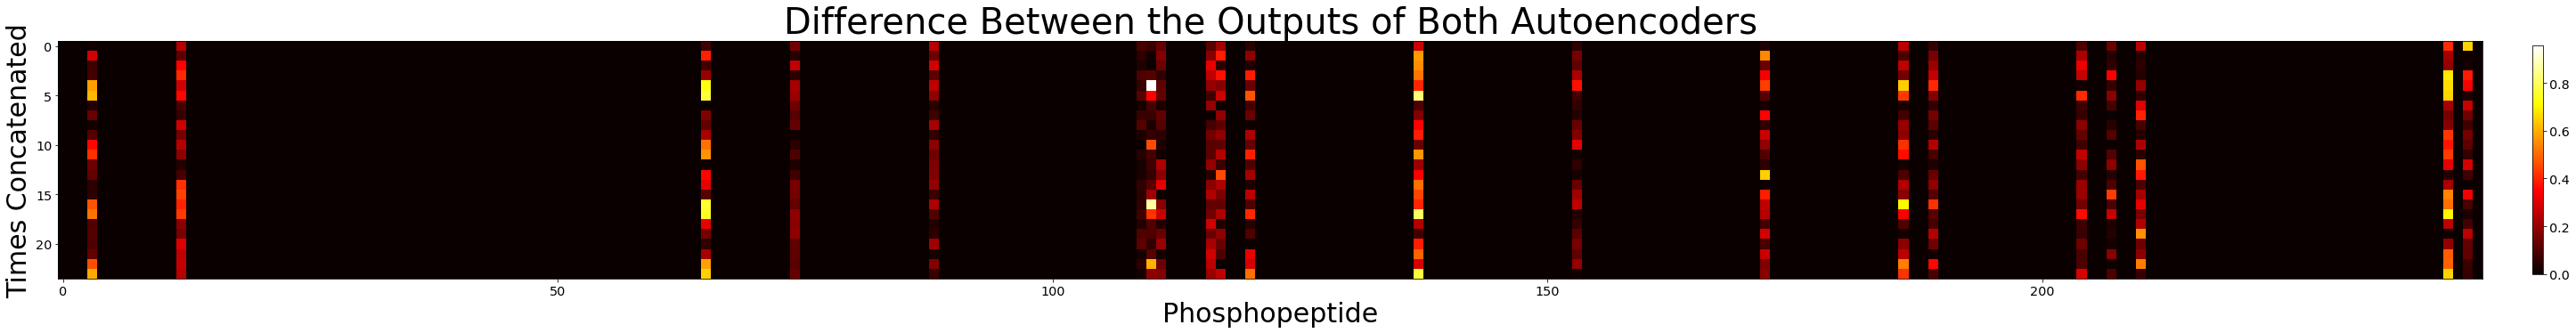

In [60]:
plt.figure(figsize=(50, 50))
u = plt.imshow(np.reshape((np.abs(outSyn-outInter)), (24,245)), cmap = "hot")#, vmin=0,vmax=1.0 );
plt.title("Difference Between the Outputs of Both Autoencoders", fontsize = 40);
plt.xlabel("Phosphopeptide", fontsize = 30);
plt.ylabel("Times Concatenated", fontsize = 30);
plt.colorbar(u ,fraction=0.0046, pad=0.02);
#plt.savefig("DiffBetweenOut.png")

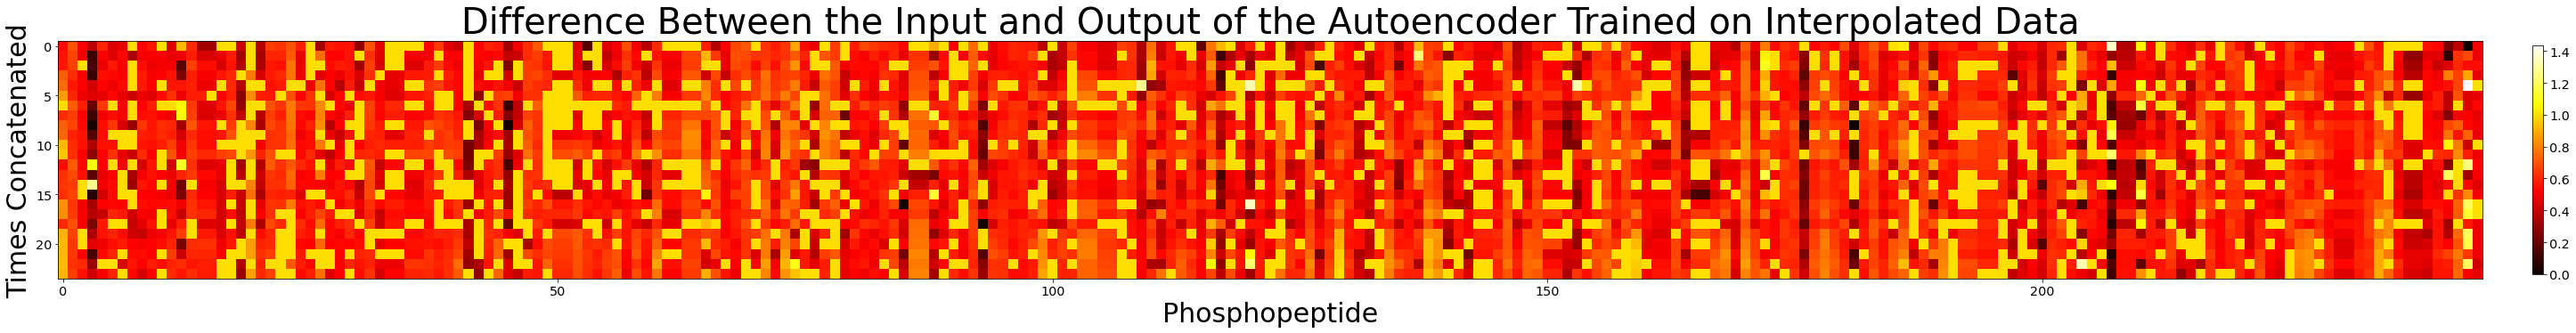

In [61]:
plt.figure(figsize=(50, 50))
u = plt.imshow(np.reshape(np.abs(outInter-experiment1), (24,245)) , cmap = "hot") #, vmin=0,vmax=1.0 )
plt.title("Difference Between the Input and Output of the Autoencoder Trained on Interpolated Data", fontsize = 40);
plt.xlabel("Phosphopeptide", fontsize = 30)
plt.ylabel("Times Concatenated", fontsize = 30);
plt.colorbar(u ,fraction=0.0046, pad=0.02);
#plt.savefig("InterDiffImage.png")

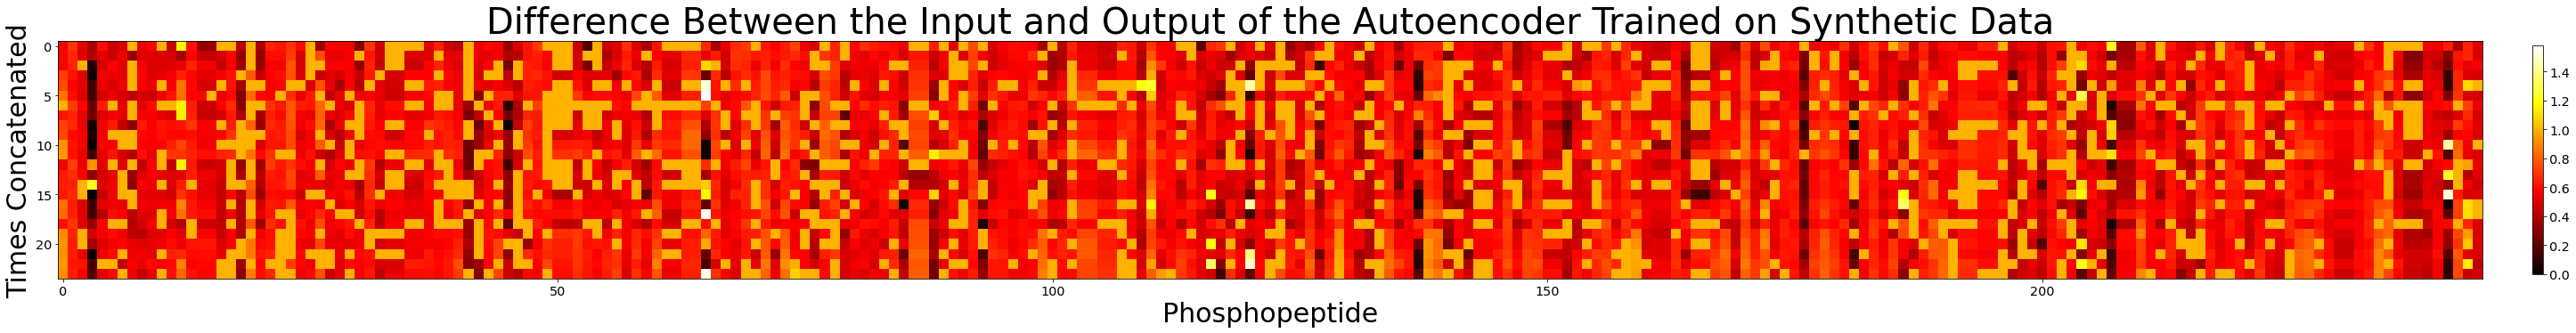

In [62]:
plt.figure(figsize=(50, 50))
u = plt.imshow(np.reshape(np.abs(outSyn-experiment1), (24,245)), cmap = "hot")#, vmin=0,vmax=1.0 )
plt.title("Difference Between the Input and Output of the Autoencoder Trained on Synthetic Data", fontsize = 40);
plt.xlabel("Phosphopeptide", fontsize = 30);
plt.ylabel("Times Concatenated", fontsize = 30);
plt.colorbar(u ,fraction=0.0046, pad=0.02);
#plt.savefig("SynDiffImage.png");

(24, 21)


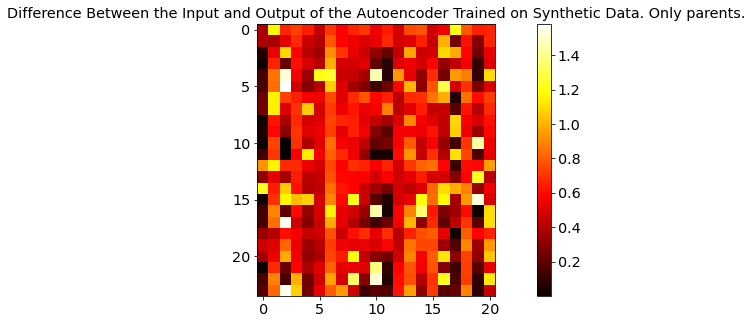

In [63]:
parent_idx = parentIndex.numpy()
#print(parent_idx)
oSyn = (np.reshape((outSyn), (24,245)).T)[parent_idx]
oSyn = oSyn.T
oSyn.shape

exp1_col = (np.reshape((experiment1), (24,245)).T)[parent_idx]
exp1_col = exp1_col.T
print(exp1_col.shape)

u = plt.imshow(np.abs(oSyn - exp1_col), cmap = 'hot') #TODO use TF loss function instead of difference.
ddff = oSyn-exp1_col
plt.colorbar(u)
plt.title("Difference Between the Input and Output of the Autoencoder Trained on Synthetic Data. Only parents.");

In [64]:
pd.DataFrame(oSyn).head(24)

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,20
0,-0.060659,0.165744,-0.334489,-0.084506,-0.088553,0.250526,-0.326909,0.177368,0.131010,-0.210773,...,-0.186104,-0.009329,-0.314113,-0.212068,-0.157514,-0.087547,0.213435,-0.209744,0.006435,-0.064178
1,0.083893,0.126743,-0.143181,-0.077311,0.064838,0.238711,-0.243617,0.123096,0.188887,-0.041056,...,-0.128993,-0.002154,-0.071458,-0.071999,-0.155991,-0.002478,0.076892,-0.229980,0.273670,-0.078267
2,0.225896,0.011097,0.082886,0.002890,0.113249,0.278678,-0.375565,0.081715,0.207500,0.058609,...,0.286727,0.024506,-0.027576,0.123056,-0.192925,0.087563,-0.015997,-0.126304,0.390148,0.030251
3,0.417360,-0.078311,0.154363,0.019669,0.021739,0.219296,-0.456627,0.172374,0.259068,0.043892,...,0.483619,0.013066,-0.092528,0.185131,-0.183688,0.179198,-0.043312,-0.071500,0.570473,0.095983
4,0.618410,-0.252255,0.522541,0.033474,0.189254,0.206030,-0.595128,0.172886,0.323704,0.186998,...,0.499960,-0.063824,-0.104841,0.350228,-0.171908,0.221797,-0.060764,-0.120766,0.736997,0.094355
5,0.792913,-0.247441,0.580534,0.098510,0.187986,0.133762,-0.558739,0.179254,0.306589,0.311561,...,0.808043,-0.070405,0.009179,0.397383,-0.210802,0.284852,0.002262,-0.070789,0.937159,0.075580
6,-0.015312,0.151083,-0.308657,-0.020814,0.010458,0.178554,-0.243341,0.199136,0.129685,-0.222102,...,-0.175300,0.061820,-0.269324,-0.131191,-0.152883,-0.014179,0.270407,-0.154015,0.028163,-0.074059
7,0.132568,0.147545,-0.154282,-0.037323,0.057932,0.168667,-0.125228,0.108837,0.152209,-0.040516,...,-0.117898,0.070367,-0.110832,-0.029438,-0.145539,0.061061,0.131278,-0.193462,0.196094,-0.071548
8,0.189894,0.078574,-0.044598,-0.011492,0.099001,0.205193,-0.152293,0.006248,0.154344,0.023178,...,0.173355,0.041193,-0.093581,0.137021,-0.161077,0.094538,0.083222,-0.100189,0.271769,0.014989
9,0.290412,0.052537,0.077529,-0.012482,0.029271,0.147492,-0.147568,0.079109,0.157093,0.033050,...,0.357122,0.002634,-0.185238,0.187180,-0.147311,0.121457,0.067144,-0.092617,0.377977,0.062493


In [65]:
pd.DataFrame(exp1_col).head(24)


,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,20
0,0.311232,-1.000000,-1.000000,0.645008,0.554178,0.690925,0.372292,0.747749,0.794170,0.495021,...,0.455733,0.472685,0.439632,0.565228,0.317936,0.461916,-1.000000,-1.000000,0.654674,0.595213
1,0.476887,0.500798,0.372761,0.601316,0.522340,0.637735,0.535247,0.707668,0.727453,0.455223,...,0.541840,0.473143,0.425360,0.582488,0.284989,-1.000000,0.331113,0.386311,0.570334,0.587421
2,0.287767,0.537002,-1.000000,0.574648,0.523913,0.632452,0.534896,0.786278,0.743514,0.512682,...,0.514102,0.454378,-1.000000,0.581471,0.285557,-1.000000,-1.000000,0.455556,0.643895,0.558828
3,0.440943,0.578982,0.374815,0.635557,0.516269,0.629227,0.533493,0.653258,0.734303,0.552866,...,0.571450,0.508228,0.451286,0.664863,0.399603,0.511530,0.391555,0.491323,0.679073,0.593245
4,0.478201,0.598115,-1.000000,0.597923,0.538137,-1.000000,0.654905,0.629435,0.768833,0.556352,...,0.571788,-1.000000,0.426957,0.674205,0.511240,0.481536,-1.000000,-1.000000,0.627382,-1.000000
5,0.647987,0.592460,-1.000000,0.558520,0.478564,0.544962,0.509113,0.680942,0.671935,0.590083,...,0.569570,0.511285,-1.000000,0.706922,0.562933,-1.000000,0.484528,0.622751,0.667441,0.564833
6,0.218619,-1.000000,0.417378,0.628405,0.564403,0.711581,-1.000000,0.702340,0.808966,-1.000000,...,0.479980,0.475295,0.408973,0.555106,-1.000000,-1.000000,0.208531,-1.000000,0.630546,0.648886
7,0.383528,-1.000000,0.349100,0.655232,-1.000000,0.645061,0.590947,0.654156,0.782149,0.489829,...,-1.000000,0.492713,0.406376,0.615306,0.299354,0.503437,0.313722,0.427484,0.611733,0.597254
8,0.213567,0.697178,0.338363,0.662920,0.580581,0.713232,0.589343,0.673497,0.808274,0.542478,...,0.542131,0.532364,-1.000000,0.689703,0.336281,0.533574,-1.000000,0.463282,0.766182,0.630140
9,0.340220,0.644924,0.387990,0.686608,0.539759,0.681096,0.577242,0.597485,0.809513,0.586733,...,0.554080,0.557906,0.370342,0.723331,0.474744,0.549192,-1.000000,0.443230,0.727473,0.650377


In [66]:
pd.DataFrame(ddff).head(24)


,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,20
0,-0.371892,1.165744,0.665511,-0.729514,-0.642731,-0.440399,-0.699201,-0.570382,-0.663161,-0.705794,...,-0.641837,-0.482014,-0.753745,-0.777296,-0.475450,-0.549463,1.213435,0.790256,-0.648239,-0.659391
1,-0.392993,-0.374055,-0.515941,-0.678628,-0.457502,-0.399024,-0.778863,-0.584573,-0.538567,-0.496279,...,-0.670833,-0.475297,-0.496818,-0.654488,-0.440980,0.997522,-0.254221,-0.616291,-0.296664,-0.665688
2,-0.061870,-0.525905,1.082886,-0.571758,-0.410664,-0.353774,-0.910461,-0.704562,-0.536014,-0.454073,...,-0.227375,-0.429872,0.972424,-0.458414,-0.478482,1.087563,0.984003,-0.581859,-0.253746,-0.528577
3,-0.023583,-0.657293,-0.220451,-0.615889,-0.494531,-0.409931,-0.990121,-0.480885,-0.475235,-0.508974,...,-0.087831,-0.495162,-0.543814,-0.479733,-0.583291,-0.332333,-0.434867,-0.562823,-0.108600,-0.497262
4,0.140209,-0.850370,1.522541,-0.564449,-0.348883,1.206030,-1.250033,-0.456548,-0.445128,-0.369353,...,-0.071828,0.936176,-0.531799,-0.323977,-0.683148,-0.259739,0.939236,0.879234,0.109616,1.094355
5,0.144926,-0.839901,1.580534,-0.460011,-0.290577,-0.411200,-1.067852,-0.501688,-0.365346,-0.278521,...,0.238473,-0.581690,1.009179,-0.309540,-0.773735,1.284852,-0.482267,-0.693540,0.269718,-0.489253
6,-0.233931,1.151083,-0.726035,-0.649219,-0.553945,-0.533027,0.756659,-0.503204,-0.679281,0.777898,...,-0.655280,-0.413475,-0.678297,-0.686297,0.847117,0.985821,0.061876,0.845985,-0.602383,-0.722945
7,-0.250960,1.147545,-0.503382,-0.692555,1.057932,-0.476393,-0.716175,-0.545319,-0.629940,-0.530345,...,0.882102,-0.422346,-0.517209,-0.644743,-0.444894,-0.442377,-0.182444,-0.620946,-0.415639,-0.668801
8,-0.023673,-0.618604,-0.382961,-0.674412,-0.481580,-0.508039,-0.741636,-0.667249,-0.653930,-0.519300,...,-0.368776,-0.491171,0.906419,-0.552681,-0.497358,-0.439037,1.083222,-0.563471,-0.494413,-0.615151
9,-0.049808,-0.592388,-0.310462,-0.699089,-0.510488,-0.533604,-0.724810,-0.518376,-0.652419,-0.553683,...,-0.196958,-0.555272,-0.555579,-0.536151,-0.622056,-0.427735,1.067144,-0.535847,-0.349496,-0.587883


In [67]:
# np.save("interpolated_v2.npy", inter) #the interpolated dataset
# np.save("synthetic_v2.npy", genes_intensities_normalized[1:]) # the synthetic dataset
# np.save("synOut_v2.npy", outSyn) #the output of the encoder trained on synthetic data with the input being exp1
# np.save("interOut_v2.npy", outInter) #the output of the encoder trained on interpolated data with the input being exp1

# Super parent with the synthetic dataset 
because the synthetic dataset performed the best

In [68]:
class EncoderLinearSuperParent(tf.keras.layers.Layer):
    def __init__(self, rgm, oldrgm, input_dim=32, units=32):
        super(EncoderLinearSuperParent, self).__init__()
        self.rgm = rgm
        self.OGrgm = oldrgm
        
        def init_weights(shape, dtype="float32"):

            w_init = tf.random_normal_initializer()(shape=shape, dtype=dtype) * tf.convert_to_tensor(self.OGrgm, dtype=dtype)

            return w_init
        

        self.w = tf.Variable(
            initial_value=init_weights(shape=(input_dim, units), dtype="float32"),
            trainable=True,
        )

    def call(self, inputs):
        X = inputs
        return tf.matmul(X, tf.multiply(self.rgm, self.w))
    #tf.matmul(inputs, self.w)

class DecoderLinearSuperParent(tf.keras.layers.Layer):
    def __init__(self, rgm, oldrgm, input_dim=32, units=32):
        super(DecoderLinearSuperParent, self).__init__()
        self.rgm = rgm
        self.OGrgm = oldrgm

        def init_weights(shape, dtype="float32"):

            w_init = tf.random_normal_initializer()(shape=shape, dtype=dtype) * tf.transpose(tf.convert_to_tensor(self.OGrgm, dtype=dtype))

            return w_init
    
        
        self.w = tf.Variable(
            initial_value=init_weights(shape=(input_dim, units), dtype="float32"),
            trainable=True,
        )

    def call(self, inputs):
        X = inputs
        #return tf.matmul(X, tf.multiply((self.rgm), self.w))
        X = tf.matmul(X, tf.multiply(tf.transpose(self.rgm), self.w)) 
        #return tf.matmul(inputs, self.w)
        # v = tf.zeros_like(X)
        # u = tf.ones_like(X)
        # u = tf.math.scalar_mul(-3.0, u)
        
        return X#tf.where(tf.math.less(X, v), u, X) #where X is less than 0, return -1 
        
        
def encoder(parent_child_biological_association, num_hidden_units=21):
    '''
    Encoder structure
    '''
    '''
    The data is time-series. Therefore, CNN to learn the temporal relationship between 
    the intensities for each gene.
    '''
    en_conv = Conv1D(32, 3, activation = "relu")(parent_child_biological_association) # 6*245
    en_dense = Flatten()(en_conv)
    phenotype = Dense(num_hidden_units)(en_dense)
    return phenotype

def decoder(X, num_protein_gene, time_steps):
    '''
    Decoder structure
    '''
    de_dense = Dense(128)(X)
    de_dense = Reshape((1, 128))(de_dense) #tf.reshape(de_dense, (self.batch_size,1,128))
    de_deconv = Conv1DTranspose(num_protein_gene, time_steps, activation = "relu")(de_dense) #used to be transpose
    #de_deconv = Conv1D(num_protein_gene, time_steps, activation = "relu")(de_dense) 
    # gene_reconstruction = self.decoder_biological_operation(de_deconv)
    return de_deconv

def modelSuperParent(rgm, oldRGM, num_protein_gene, time_steps, num_kinase_regulators, num_hidden_units = 21): #rgm is set to superparent, oldrgm is original rgm unmodified
    inp = Input(shape=(time_steps, num_kinase_regulators))
    x = EncoderLinearSuperParent(rgm, oldRGM, 245, 245)(inp)
    enc = encoder(x, num_hidden_units)
    dec = decoder(enc, num_protein_gene, time_steps)
    out = DecoderLinearSuperParent(rgm, oldRGM, 245, 245)(dec)

    _model = tf.keras.Model(inputs=inp, outputs=out)

    return _model

In [69]:
def modelSuperParentSequential(rgm, oldRGM, num_protein_gene, time_steps, num_kinase_regulators, num_hidden_units = 21): #rgm is set to superparent, oldrgm is original rgm unmodified
    m = tf.keras.Sequential()
    inp = Input(shape=(time_steps, num_kinase_regulators))
    x = EncoderLinearSuperParent(rgm, oldRGM, 245, 245)(inp)
    enc = encoder(x, num_hidden_units)
    dec = decoder(enc, num_protein_gene, time_steps)
    out = DecoderLinearSuperParent(rgm, oldRGM, 245, 245)(dec)

    _model = tf.keras.Model(inputs=inp, outputs=out)

    return _model

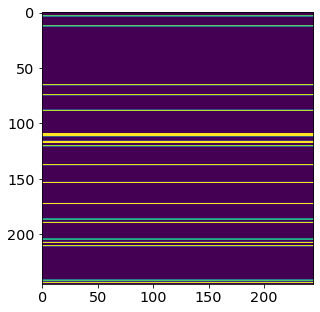

In [70]:
plt.imshow(superParent)

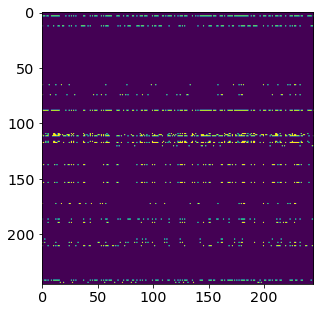

In [71]:
plt.imshow(regulator_gene_matrix)

In [72]:
looseParent = modelSuperParent(superParent, regulator_gene_matrix, 245, 6, 245, 21)
looseParent.compile(optimizer='adam', loss=ignore_noParent_MSE)
looseParent.fit(syntheticDataTrain, syntheticDataTrain, epochs=240, verbose = 0)

In [73]:
ignore_noParent_MSE(testCandidate, k := looseParent.predict(testCandidate)) #used to be 5.144 on old ignore parent

1/1 [==============================] - 0s 114ms/step


<tf.Tensor: shape=(), dtype=float32, numpy=0.31938058>

In [74]:
u = np.reshape(k, (24,245))
u = pd.DataFrame(u)
u.head()

,0,1,2,3,4,5,6,7,8,9,...,235,236,237,238,239,240,241,242,243,244
0,0.0,0.0,0.0,-0.070981,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,-0.007743,0.0,0.032559,0.0
1,0.0,0.0,0.0,0.028521,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.172906,0.0,0.046153,0.0
2,0.0,0.0,0.0,0.274614,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.417287,0.0,0.082872,0.0
3,0.0,0.0,0.0,0.450598,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.595163,0.0,0.086314,0.0
4,0.0,0.0,0.0,0.669179,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.766875,0.0,0.094992,0.0


In [75]:
u = np.reshape(testCandidate, (24,245))
u = pd.DataFrame(u)
u.head()

,0,1,2,3,4,5,6,7,8,9,...,235,236,237,238,239,240,241,242,243,244
0,0.630290,0.629271,0.688235,0.332625,0.572247,0.651327,0.709770,0.27651,0.461589,0.442091,...,0.811426,0.836935,0.348147,0.348147,0.425058,0.390865,0.572641,0.605758,0.520441,0.460282
1,0.679429,0.598782,0.679060,0.312948,0.501809,0.694769,0.736314,-1.00000,0.562616,0.502785,...,0.803799,0.773869,0.430436,0.430436,0.520618,0.377990,0.629725,0.627226,0.603480,-1.000000
2,0.679668,0.569034,0.660106,0.321653,0.508297,0.685786,0.704436,-1.00000,0.527585,0.458724,...,0.829671,0.841796,0.414461,0.414461,0.429398,0.384251,0.617261,0.631014,0.578434,0.455383
3,0.622666,0.631905,0.664430,0.362718,0.481386,0.650971,0.754691,0.18287,0.517533,0.484508,...,0.737947,0.772426,0.345331,0.345331,0.495079,0.376468,0.682103,0.500355,0.577239,0.456085
4,0.765695,0.592536,0.670325,0.447501,0.469679,0.588251,0.734281,-1.00000,0.501568,0.414366,...,0.784941,0.754746,0.363333,0.363333,0.494566,0.547184,0.614375,0.613839,0.533392,0.447694


In [76]:
# avgMSE = np.average(lossMatrix, axis = 0)
# plt.plot(np.arange(2,33,2), avgMSE);

# DenseNetAutoEncoder

In [77]:
'''
a second copy of the layers which will be modified to be a denseNET auto encoder
'''
#TODO: fix call to map to -1?
class DenseEncoderLinear2(tf.keras.layers.Layer): #TODO: Fix the decoder to -1
    def __init__(self, rgm, oldrgm, input_dim=32, units=32):
        super(DenseEncoderLinear2, self).__init__()
        self.rgm = rgm
        self.oldrgm = oldrgm
        
        def init_weights(shape, dtype="float32"):

            w_init = tf.random_normal_initializer()(shape=shape, dtype=dtype) * tf.convert_to_tensor(self.oldrgm, dtype=dtype)

            return w_init
        

        self.w = tf.Variable(
            initial_value=init_weights(shape=(input_dim, units), dtype="float32"),
            trainable=True,
        )

    def call(self, inputs):
        X = inputs
        return tf.matmul(X, tf.multiply(self.rgm, self.w))
    #tf.matmul(inputs, self.w)

    def get_config(self):
        config = super().get_config()
        config.update({
            "rgm": self.rgm,
            "oldrgm": self.oldrgm,
            'input_dim': 32,
            'units' : 32
        })

class DenseDecoderLinear2(tf.keras.layers.Layer):
    def __init__(self, rgm, oldrgm, input_dim=32, units=32):
        super(DenseDecoderLinear2, self).__init__()
        self.rgm = rgm
        self.oldrgm = oldrgm

        def init_weights(shape, dtype="float32"):

            w_init = tf.random_normal_initializer()(shape=shape, dtype=dtype) * tf.transpose(tf.convert_to_tensor(self.oldrgm, dtype=dtype))

            return w_init

        self.w = tf.Variable(
            initial_value=init_weights(shape=(input_dim, units), dtype="float32"),
            trainable=True,
        )

    def call(self, inputs):
        X = inputs
        #return tf.matmul(X, tf.multiply((self.rgm), self.w))
        return tf.matmul(X, tf.multiply(tf.transpose(self.rgm), self.w)) #used to have a transpose
        #return tf.matmul(inputs, self.w)

    def get_config(self):
        config = super().get_config()
        config.update({
            "rgm": self.rgm,
            "oldrgm": self.oldrgm,
            'input_dim': 32,
            'units' : 32
        })
        

def denseencoder2(parent_child_biological_association, inp, num_hidden_units=21):
    '''
    Encoder structure
    '''
    '''
    The data is time-series. Therefore, CNN to learn the temporal relationship between 
    the intensities for each gene.
    '''
    en_conv = Conv1D(490, 3, activation = "tanh")(parent_child_biological_association) # 6*245
    en_dense = Flatten()(en_conv)
    inp = Flatten()(inp)
    #print(en_dense.shape, inp.shape)
    d = Concatenate()([en_dense, inp]) #dense layer
    en_dense = Dense(1024)(d) #added a layer
    
    phenotype = Dense(num_hidden_units, activation="tanh")(d)
    return phenotype

def densedecoder2(X, num_protein_gene, time_steps):
    '''
    Decoder structure
    '''
    de_dense = Dense(1024)(X)
    de_dense = Dense(256)(de_dense)#added a layer
    de_dense = Reshape((1, 256))(de_dense) #tf.reshape(de_dense, (self.batch_size,1,128))
    de_deconv = Conv1DTranspose(num_protein_gene, time_steps, activation = "tanh")(de_dense) #used to be transpose
    #de_deconv = Conv1D(num_protein_gene, time_steps, activation = "relu")(de_dense) 
    # gene_reconstruction = self.decoder_biological_operation(de_deconv)
    return de_deconv

def modelDense2(rgm, oldrgm, num_protein_gene, time_steps, num_kinase_regulators, num_hidden_units = 21):
    inp = Input(shape=(time_steps, num_kinase_regulators))
    x = DenseEncoderLinear2(rgm, oldrgm, 245, 245)(inp)
    #x = EncoderLinear2(x)
    enc = denseencoder2(x, inp, num_hidden_units)
    dec = densedecoder2(enc, num_protein_gene, time_steps)
    out = DenseDecoderLinear2(rgm, oldrgm, 245, 245)(dec)

    _model = tf.keras.Model(inputs=inp, outputs=out)

    return _model

In [78]:
dense = modelDense2(superParent, regulator_gene_matrix, 245, 6, 245, 21)
dense.compile(optimizer='adam', loss=ignore_noParent_MSE)
dense.fit(genes_intensities_normalized, genes_intensities_normalized, epochs=1000,  verbose=0)

test = dense(testCandidate) #, verbose = 0)
loss = ignore_noParent_MSE(testCandidate, test)
loss

<tf.Tensor: shape=(), dtype=float32, numpy=0.19753216>

In [130]:
dense.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 6, 245)]     0           []                               
                                                                                                  
 dense_encoder_linear2 (DenseEn  (None, 6, 245)      60025       ['input_1[0][0]']                
 coderLinear2)                                                                                    
                                                                                                  
 conv1d (Conv1D)                (None, 4, 490)       360640      ['dense_encoder_linear2[0][0]']  
                                                                                                  
 flatten (Flatten)              (None, 1960)         0           ['conv1d[0][0]']             

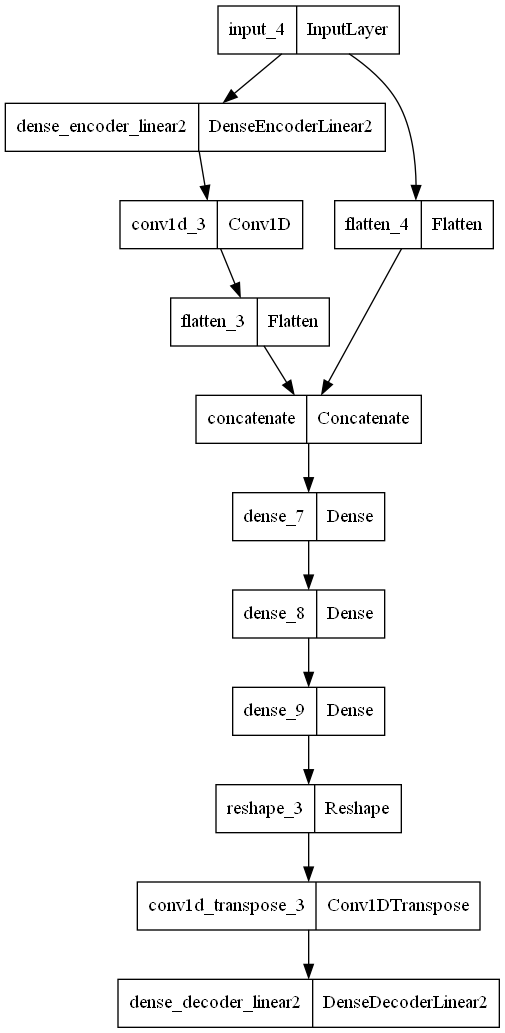

In [79]:
tf.keras.utils.plot_model(dense)

In [102]:
N = 50
hidden = np.arange(2,33, 1) #range(1,32)
lossMatrix = []
for i in tqdm(range(N)):
    
    
    losses = []
    for value in (hidden):
        dense = modelDense2(superParent, regulator_gene_matrix, 245, 6, 245, value)
        dense.compile(optimizer='adam', loss=ignore_noParent_MSE)
        dense.fit(genes_intensities_normalized, genes_intensities_normalized, epochs=20,  verbose=0)

        test = dense(testCandidate) #, verbose = 0)
        loss = ignore_noParent_MSE(testCandidate, test)
        losses.append(loss)
        tf.keras.backend.clear_session()
    lossMatrix.append(losses)
    
lossMatrix = np.array(lossMatrix)
#run 100 times 

100%|██████████| 50/50 [48:24<00:00, 58.09s/it]


Text(0.5, 1.0, 'MSE of the AutoEncoder with Respect to the Latent Space Size')

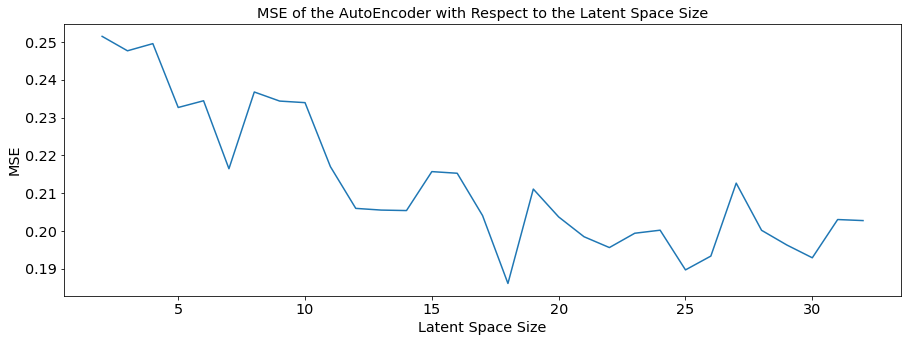

In [104]:
avgMSE = np.average(lossMatrix, axis = 0)
plt.plot(hidden, avgMSE);
plt.xlabel("Latent Space Size");
plt.ylabel("MSE");
plt.title("MSE of the AutoEncoder with Respect to the Latent Space Size");

# Lazy Kernels

In [82]:
parent_idx

array([  3,  12,  65,  74,  88, 109, 110, 111, 116, 117, 120, 137, 153,
       172, 186, 189, 204, 207, 210, 241, 243])

In [89]:
def do_lazy_train(epochs=60, hidden = 32):
    ep = epochs
    hidden = [hidden,] #range(1,32)
    lossMatrix = []
    lazy_weights = []
    dense = modelDense2(superParent, regulator_gene_matrix, 245, 6, 245, num_hidden_units=32)
    dense.compile(optimizer='adam', loss=ignore_noParent_MSE)

    #for i in tqdm(range(ep)):
    for i in range(ep):
        dense.fit(genes_intensities_normalized, genes_intensities_normalized, epochs=1,  verbose=0)
        lazy_weights.append(dense.get_weights())
        test = dense(testCandidate) #, verbose = 0)
        loss = ignore_noParent_MSE(testCandidate, test)
        lossMatrix.append(loss)
        
    lossMatrix = np.array(lossMatrix)
    lazy_weights = np.array(lazy_weights)

    return lossMatrix, lazy_weights

In [100]:
#https://proceedings.mlr.press/v162/rachwan22a/rachwan22a.pdf Winning the Lottery Ticket Ahead of Time:
def lazyKernelRegime(w, parent_idx=parent_idx):

    firstLayer = []
    for i in range(len(w)):
        firstLayer.append(w[i][0][parent_idx])

    fL = np.array(firstLayer)    
    d0 = np.square(fL[1] - fL[0])
    kernelChange = []
    for i in range(1,len(fL)):
        dt = np.square(fL[i] - fL[0])
        dt_minus1 = np.square(fL[i-1] - fL[0])   
        d = np.abs(dt - dt_minus1)/d0                        #eq 11 from the paper
        kernelChange.append(d)
    
    kernelChange = np.moveaxis(kernelChange, 0, 2)
    return np.array(  kernelChange)

In [226]:
def compute_distrib(change, t = .05, raw = False): #raw means return the unshaped indicies. 
    stop = []

    for parent in range(len(change)):
        for child in range(len(change[0])):
            try:
                stop.append(np.min(np.argwhere(change[parent][child] < t)))
            except ValueError:
                stop.append(len(change))
                # print(parent, child)
                # plt.plot(change[parent][child])
                # assert(False)
    # print(change.shape)
    # assert(False)
    
    stop = np.array(stop).flatten()
    # print(stop.shape)
    var = np.std(stop)
    # print(var)
    # assert(False)
    mean = np.average(stop)
    top_parents = np.argwhere(stop > mean + 2*var) #get the parents which take more than 2 stds to stop training
    top_parent_child = []
    for tp in top_parents:
        top_parent_child.append(np.unravel_index(tp, shape = (NUM_PARENTS, NUM_TARGETS)))

    if raw == False:
        plt.hist(stop)
        plt.xlabel("Epoch where regulator-target-weight began changing by at most "+ str(t))
        plt.ylabel("Number of parent-child-weights")
        plt.title("Histogram of weight stops")
        print("average stop: ", mean)

    if raw == True:
        return np.array(top_parents)

    return np.array(top_parent_child)

In [224]:
def lazyKernels(N=10):

    candidates = []
    final_w = []
    for i in tqdm(range(N)):
        lm, lazy_weights = do_lazy_train(epochs=80)
        change = lazyKernelRegime(lazy_weights)
        top_pr = np.squeeze(compute_distrib(change, t = 0.05, raw=True))
        candidates.append(top_pr)
        final_w.append(lazy_weights[-1])
    
    final_w = np.array(final_w)
    firstLayer = []
    for i in range(len(final_w)):
        firstLayer.append(np.abs(final_w[i][0][parent_idx]))
    fw = np.array(firstLayer)
    #print(fw.shape)
    fw_avg = np.average(fw, axis = 0)
    #print(fw_avg.shape)
    
    candidates = np.hstack(candidates)
    candidates = candidates.reshape(candidates.size)
    #print(candidates.shape)

    plt.hist(candidates, bins=np.arange(0, NUM_PARENTS*NUM_TARGETS))
    plt.title("Parent-Child Regulator Histogram")
    plt.xlabel("Parent-Child Weight")
    plt.ylabel("Num-Times parent-child relationship trained for top 5% of time")
    return candidates, fw_avg



In [225]:
can, mag = lazyKernels()

  0%|          | 0/10 [00:07<?, ?it/s]

(21, 245, 79)


AssertionError: 

In [187]:
pdf, bins = np.histogram(can, np.arange(NUM_PARENTS*NUM_TARGETS))
pdf

array([0, 0, 0, ..., 0, 1, 0], dtype=int64)

In [188]:
mag.shape

(21, 245)

# Magnitudes After Training

In [210]:
NUM_PARENTS*NUM_TARGETS

5145

In [229]:
np.unravel_index(5144, shape = (NUM_PARENTS, NUM_TARGETS))

(20, 244)

In [221]:
def get_top_reg_targets(can, mag):
    
    pdf, bins = np.histogram(can, np.arange(0, NUM_PARENTS*NUM_TARGETS))
    pdf2d = np.zeros(shape = (NUM_PARENTS,NUM_TARGETS))

    for i in bins:
      idx2d = np.unravel_index(i, shape = (NUM_PARENTS, NUM_TARGETS))
      try:
        pdf2d[idx2d] = pdf[i]
      except IndexError:
        print(i, idx2d, len(pdf), len(bins))
    

    importance = np.multiply(pdf2d, mag)
    return importance

In [222]:
top = get_top_reg_targets(can, mag)

5144 (20, 244) 5144 5145


In [231]:
top.shape

(21, 245)

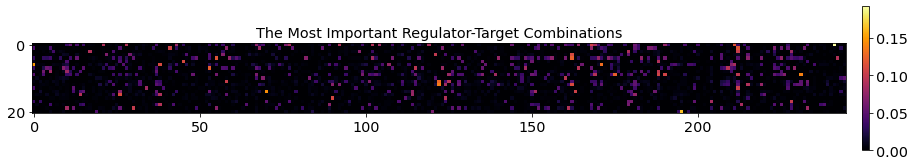

In [239]:
u = plt.imshow(top, cmap = 'inferno');
plt.colorbar(u ,fraction=0.0086, pad=0.02);
plt.title("The Most Important Regulator-Target Combinations");

241

In [252]:
top[best]

IndexError: index 241 is out of bounds for axis 0 with size 21

In [ ]:
top[]

In [198]:
np.unique(can).size

2177

(array([1., 1., 1., ..., 1., 2., 4.]),
 array([   2,    7,   10, ..., 5139, 5140, 5144], dtype=int64),
 <BarContainer object of 1939 artists>)

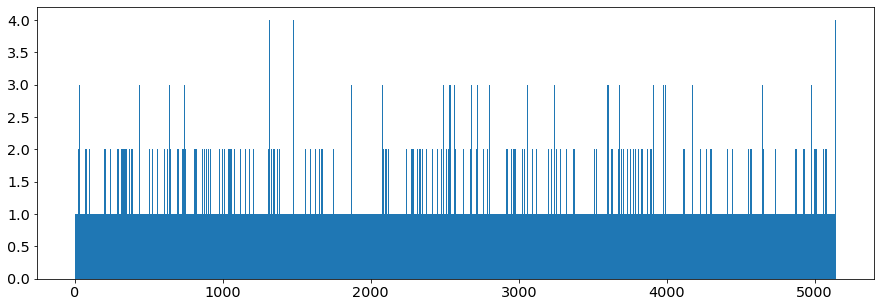

In [136]:
plt.hist(can, bins=np.unique(can))

# Inference on Petal Len

In [85]:
petal = pd.read_excel(data_path_petal)

In [86]:
petal_train = petal[petal["Line"] == "WT"]
petal_train = petal_train.drop(columns=['Line', 'ID', "Treatment"])
petal_train.head(12)
petal_train = petal_train.groupby(['Plate']).mean()
petal_train.head()
petal_train = petal_train.to_numpy()
print(petal_train.shape)
scaler1 = StandardScaler()
scaler1.fit(petal_train)
petal_train = scaler1.transform(petal_train)
mm = MinMaxScaler()
mm.fit(petal_train)
petal_train = mm.transform(petal_train)
petal_train

(4, 1)


array([[0.95361071],
       [1.        ],
       [0.        ],
       [0.34194165]])

In [87]:
petal_test = petal[petal["Line"] != "WT"]
petal_test = petal_test.drop(columns=['Line', 'ID', "Treatment"])
petal_test = petal_test.groupby(['Plate']).mean()
petal_test.head()
petal_test = petal_test.to_numpy()
print(petal_test.shape)
petal_test = scaler1.transform(petal_test)
petal_test = mm.transform(petal_test)
petal_test

(4, 1)


array([[ 0.33225729],
       [-0.11669058],
       [-0.62362506],
       [-0.59851746]])

In [88]:
experiment1.shape
testCandidate.shape

(4, 6, 245)

In [118]:
densePredictor = modelDense2(superParent, regulator_gene_matrix, 245, 6, 245, 22)
densePredictor.compile(optimizer='adam', loss=ignore_noParent_MSE)
densePredictor.fit(genes_intensities_normalized, genes_intensities_normalized, epochs=20,  verbose=0)
test = densePredictor(testCandidate) #, verbose = 0)
loss = ignore_noParent_MSE(testCandidate, test)
print(loss)

tf.Tensor(0.1553365, shape=(), dtype=float32)


In [90]:
rgm = superParent
time_steps = 6
num_kinase_regulators = 245
num_hidden_units = 22

inp = Input(shape=(time_steps, num_kinase_regulators))
x = DenseEncoderLinear2(rgm, regulator_gene_matrix, 245, 245)(inp)
enc = denseencoder2(x, inp, num_hidden_units)
denseP = tf.keras.Model(inputs=inp, outputs=enc)
#set the weights of the encoder to the weights of auto encoder
dw = densePredictor.get_weights()
enc_w = dw[0:5]
denseP.set_weights(enc_w)
#add a dense layer  because we are ouputing 1 number
l = Dense(1, activation = 'tanh', use_bias=False)(denseP.layers[-1].output)
denseP = tf.keras.Model(denseP.inputs, l)
#denseP.summary()

In [91]:
bp = np.concatenate([experiment1, experiment1, experiment1, experiment1])
bp.shape
#bigexperiment1.shape

(16, 6, 245)

In [92]:
a = petal_train[0]
b = petal_train[1]
c = petal_train[2]
d = petal_train[3]

petal_train1 = np.array([a,a,a,a, b,b,b,b, c,c,c,c, d,d,d,d]) #does this make sense? we are training network to predict .5
petal_train1.shape

(16, 1)

In [93]:
denseP.compile(optimizer='adam', loss=tf.keras.losses.MeanSquaredError())
denseP.fit(experiment1, petal_train, epochs=50, verbose = 1)

Epoch 1/50
1/1 [==============================] - 1s 892ms/step - loss: 2.5890
Epoch 2/50
1/1 [==============================] - 0s 5ms/step - loss: 1.9632
Epoch 3/50
1/1 [==============================] - 0s 3ms/step - loss: 0.7906
Epoch 4/50
1/1 [==============================] - 0s 4ms/step - loss: 0.1662
Epoch 5/50
1/1 [==============================] - 0s 4ms/step - loss: 0.2691
Epoch 6/50
1/1 [==============================] - 0s 4ms/step - loss: 0.2838
Epoch 7/50
1/1 [==============================] - 0s 4ms/step - loss: 0.2746
Epoch 8/50
1/1 [==============================] - 0s 5ms/step - loss: 0.2479
Epoch 9/50
1/1 [==============================] - 0s 4ms/step - loss: 0.1941
Epoch 10/50
1/1 [==============================] - 0s 4ms/step - loss: 0.1191
Epoch 11/50
1/1 [==============================] - 0s 4ms/step - loss: 0.0919
Epoch 12/50
1/1 [==============================] - 0s 4ms/step - loss: 0.0968
Epoch 13/50
1/1 [==============================] - 0s 4ms/step - loss: 

In [94]:
testCandidate.shape

(4, 6, 245)

In [95]:
denseP(experiment1) #experiment1 is part of the training set.

<tf.Tensor: shape=(4, 1), dtype=float32, numpy=
array([[ 0.962718  ],
       [ 0.9542679 ],
       [-0.00503153],
       [ 0.46071535]], dtype=float32)>

In [96]:
petal_train

array([[0.95361071],
       [1.        ],
       [0.        ],
       [0.34194165]])

In [97]:
print(denseP(testCandidate)) #model output

tf.Tensor(
[[0.6913944 ]
 [0.3445227 ]
 [0.6992805 ]
 [0.26349583]], shape=(4, 1), dtype=float32)


In [98]:
petal_test #true label

array([[ 0.33225729],
       [-0.11669058],
       [-0.62362506],
       [-0.59851746]])

In [99]:
petal_train

array([[0.95361071],
       [1.        ],
       [0.        ],
       [0.34194165]])

In [100]:
denseP.evaluate(testCandidate, petal_test) #eval gave 1.3999 before

1/1 [==============================] - 0s 159ms/step - loss: 0.7087


0.708710789680481

# Junk

In [ ]:
d = np.zeros(shape = (3,6,8))
id = np.unravel_index(3*6*8 - 1, shape = d.shape)
d[id] = 1
plt.imshow(d[2])

In [ ]:
testCandidate[0][ : , parentIndex]

array([[ 0.33262452, -1.        ,  0.72367883,  0.47297269,  0.49418113,
         0.6420384 ,  0.50394946,  0.6847614 ,  0.73492372,  0.41228548,
         0.6689055 ,  0.41653621,  0.46169034,  0.57737494,  0.52793521,
         0.60674787,  0.73796624,  0.59914976,  0.68748152,  0.57264143,
         0.52044106],
       [ 0.31294832,  0.53610921, -1.        ,  0.48029006,  0.52149838,
         0.63579446,  0.47784179,  0.67492956,  0.76559806,  0.48408878,
         0.662256  ,  0.40146986,  0.45550761,  0.67242122,  0.58750564,
         0.5983696 ,  0.73721415,  0.63350546,  0.57812268,  0.62972462,
         0.60348046],
       [ 0.32165319, -1.        ,  0.73791933,  0.47455293,  0.42869982,
         0.62651557,  0.51567709,  0.69742841,  0.71932632,  0.48579505,
         0.7755844 , -1.        ,  0.4297246 ,  0.61820638,  0.56006104,
         0.5661965 ,  0.73307377,  0.54605776,  0.67557687,  0.61726093,
         0.57843435],
       [ 0.36271837,  0.38536492,  0.68728441,  0.45066956

In [ ]:
print(outSyn.shape)
print(testCandidate.shape)
syntheticLoss = ignore_noParent_MSE(np.array([testCandidate[0]]), np.array([outSyn[0]]) )
syntheticLoss

(4, 6, 245)
(4, 6, 245)
tf.Tensor(
[[[ 0.33262452 -1.          0.72367883  0.47297269  0.49418113
    0.6420384   0.50394946  0.6847614   0.73492372  0.41228548
    0.6689055   0.41653621  0.46169034  0.57737494  0.52793521
    0.60674787  0.73796624  0.59914976  0.68748152  0.57264143
    0.52044106]
  [ 0.31294832  0.53610921 -1.          0.48029006  0.52149838
    0.63579446  0.47784179  0.67492956  0.76559806  0.48408878
    0.662256    0.40146986  0.45550761  0.67242122  0.58750564
    0.5983696   0.73721415  0.63350546  0.57812268  0.62972462
    0.60348046]
  [ 0.32165319 -1.          0.73791933  0.47455293  0.42869982
    0.62651557  0.51567709  0.69742841  0.71932632  0.48579505
    0.7755844  -1.          0.4297246   0.61820638  0.56006104
    0.5661965   0.73307377  0.54605776  0.67557687  0.61726093
    0.57843435]
  [ 0.36271837  0.38536492  0.68728441  0.45066956  0.51011139
    0.63238078 -1.          0.66769308  0.72368777  0.51241136
    0.65023452  0.48790294  0.45640

<tf.Tensor: shape=(), dtype=float32, numpy=0.34608406>

In [ ]:
dd

Text(0, 0.5, 'change in weight')

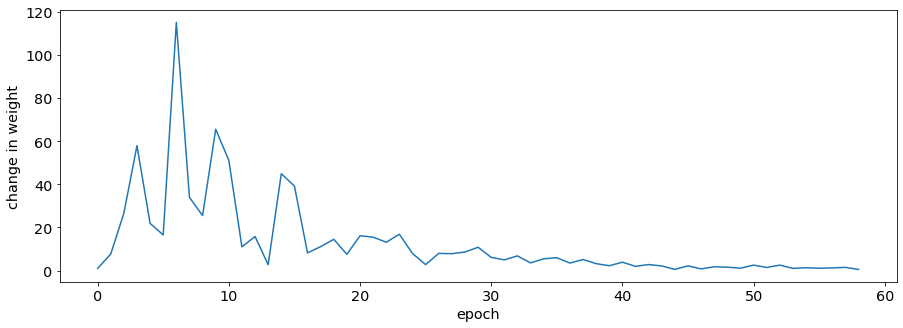

In [ ]:
plt.plot(change[0][22])
plt.xlabel("epoch")
plt.ylabel("change in weight")

Text(0, 0.5, 'MSE')

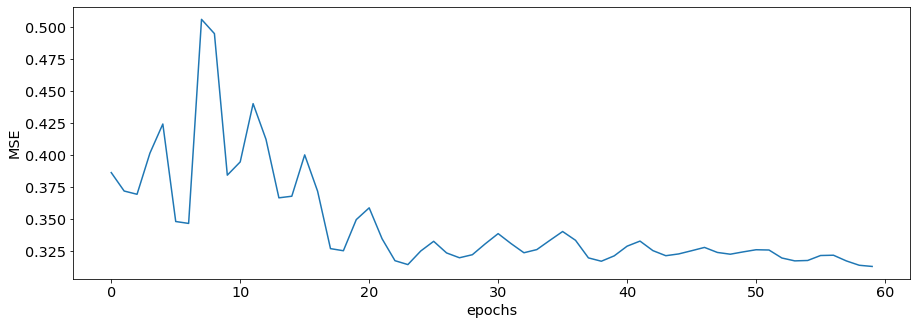

In [ ]:
plt.plot(lossMatrix)
plt.xlabel("epochs")
plt.ylabel("MSE")

In [ ]:
print(change.shape, lossMatrix.shape)

(21, 245, 59) (60,)


(58,)

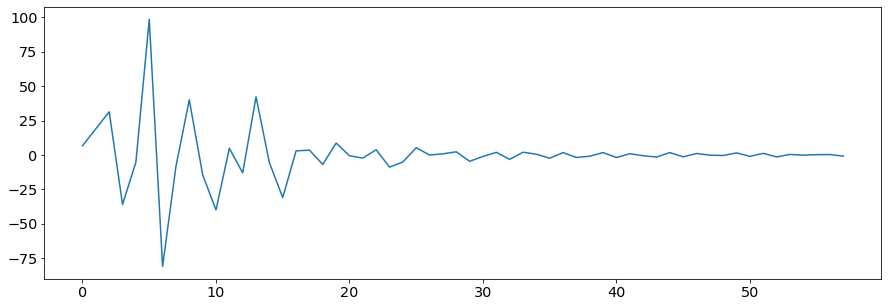

In [ ]:
d = np.diff(change[0][22])
plt.plot(d)
d.shape

In [ ]:
change[0][0].flatten()

array([1.0000000e+00, 6.2267208e+00, 8.4244858e+01, 2.3190759e+02,
       4.6938145e+01, 1.4571043e+01, 3.2468436e+02, 5.2167248e+01,
       1.9098307e+01, 2.3784262e+02, 1.4972844e+02, 9.0305321e+01,
       1.4454961e+01, 1.0191910e+01, 1.4444521e+02, 1.1422652e+02,
       4.4633780e+00, 7.0878799e+01, 1.0034342e+02, 2.4216372e+01,
       4.2676544e+01, 8.8577652e+00, 3.1776845e-02, 7.1697868e+01,
       4.3129757e+01, 1.0543992e+01, 3.4226681e+01, 1.0355385e+01,
       2.6150772e+01, 4.8526745e+00, 8.5592079e+00, 1.5769169e+01,
       5.3766422e+01, 1.8505602e+01, 1.4997946e+01, 3.8863201e+00,
       3.3604797e+01, 2.6563268e+00, 7.2169685e+00, 1.2690077e+01,
       2.8381071e+01, 7.7667198e+00, 8.0884752e+00, 1.2734420e+01,
       1.7506987e+01, 1.4849573e+01, 5.8457313e+00, 1.4414846e+01,
       4.9223903e-01, 1.8104948e+01, 6.3936701e+00, 1.4318429e+01,
       1.2278428e+01, 6.0279346e+00, 1.2717383e+01, 1.9357294e+00,
       6.8698397e+00, 7.1682763e+00, 1.3986886e+01], dtype=flo

In [ ]:
top_pr.shape

(281, 2, 1)

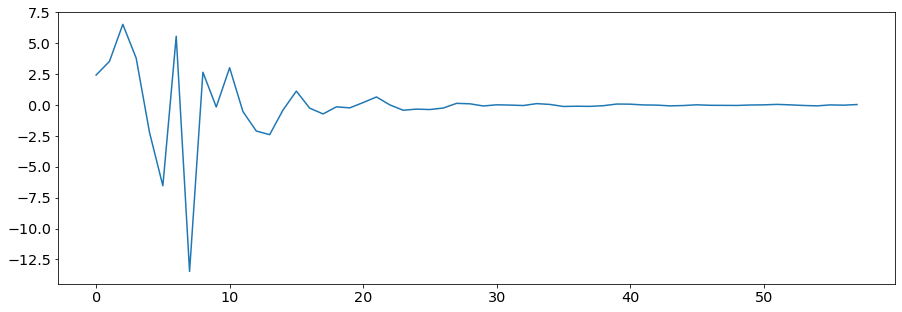

In [ ]:
plt.plot(d[0])

In [ ]:

# def compute_tresh(change, stop = 0.05):
#     diffs = []
#     for parent in range(len(change)):
#         for child in range(len(change[0])):
#             diffs.append(np.diff(change[parent][child]))
#     inflection = []


#     try:
#         for d in diffs:
#             print(np.argwhere(np.abs(d) < stop))
#             inflection.append(np.min(np.argwhere(np.abs(d) < stop))) #return where the second derivative is first 0. 

#     except ValueError:
#         print("Stop value ", stop, " is too high, trying stop = ", stop + 0.05)
#         # s = stop + 0.05
#         # return compute_tresh(change, stop = s)
        

#     return np.average(inflection)
        
# d = compute_tresh(change)
# d.shape

In [ ]:
#np.save("mse3.npy", avgMSE) #mse2/3 is with -1 fix

In [ ]:
#https://www.sciencedirect.com/science/article/pii/S0925231220314570?casa_token=lcEJANqO0JwAAAAA:uL3DGUZctPUZz_sPz1K1i2klMtb83TyKnc9CI3_N-uSOaM7VHL8GhM0jCGYfo25NmpDQQ9Cvlw

In [ ]:
rshp = Flatten()(looseParent.layers[-1].output)

modelTemp = tf.keras.Model(inputs=looseParent.input, outputs = [rshp])
modelTemp.summary()
type(modelTemp)
explainer = shap.DeepExplainer(modelTemp, syntheticDataTrain)
#shap.explainers._deep.deep_tf.op_handlers["AddV2"] = shap.explainers._deep.deep_tf.passthrough #this solves the "shap_ADDV2" problem but another one will appear
#shap.explainers._deep.deep_tf.op_handlers["FusedBatchNormV3"] = shap.explainers._deep.deep_tf.passthrough #this solves the next problem which allows you to run the DeepExplainer.

shap_values = explainer.shap_values(testCandidate[0:1])
def f(x):
    return modelTemp.predict(x)

print(f(testCandidate))
explainer = shap.KernelExplainer(f , testCandidate[0:1], link="logit") #svm.predict_proba, X_train, link="logit")
shap_values = explainer.shap_values(testCandidate[0:1], nsamples=100)
def map2layer(x, layer):
    feed_dict = dict(zip([model.layers[0].input], [preprocess_input(x.copy())]))
    return K.get_session().run(model.layers[layer].input, feed_dict)
e = shap.GradientExplainer(
    (model.layers[7].input, model.layers[-1].output),
    map2layer(X, 7),
    local_smoothing=0 # std dev of smoothing noise
)
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
import keras.backend as K
import numpy as np
import json
import shap

# load pre-trained model and choose two images to explain
model = VGG16(weights='imagenet', include_top=True)
X,y = shap.datasets.imagenet50()
to_explain = X[[39,41]]

# load the ImageNet class names
url = "https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json"
fname = shap.datasets.cache(url)
with open(fname) as f:
    class_names = json.load(f)

# explain how the input to the 7th layer of the model explains the top two classes
def map2layer(x, layer):
    feed_dict = dict(zip([model.layers[0].input], [preprocess_input(x.copy())]))
    return K.get_session().run(model.layers[layer].input, feed_dict)
e = shap.GradientExplainer(
    (model.layers[7].input, model.layers[-1].output),
    map2layer(X, 7),
    local_smoothing=0 # std dev of smoothing noise
)
shap_values,indexes = e.shap_values(map2layer(to_explain, 7), ranked_outputs=2)

# get the names for the classes
index_names = np.vectorize(lambda x: class_names[str(x)][1])(indexes)

# plot the explanations
shap.image_plot(shap_values, to_explain, index_names)